Embeddings:
(5, 2)
[[ 0.76975346  0.69300032]
 [ 0.76404238 -0.02858329]
 [-0.71907258 -0.62798452]
 [-0.45154715  0.8559947 ]
 [ 0.11469436  0.02634001]]


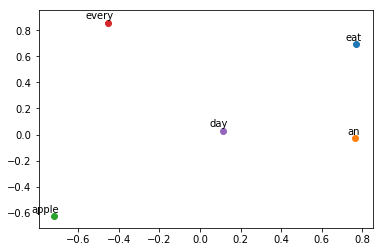

Weights:
(5, 2)
[[-0.23159575  0.53407955]
 [ 0.31063056  0.44711328]
 [ 0.6691792   0.16779852]
 [-0.07699132  0.38393474]
 [ 0.79065657 -0.66068792]]


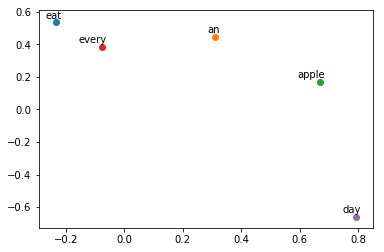

Sampled Weights:
(2, 2)
Embeddings (1) Only the first two lines change!:
(5, 2)
[[ 0.71855605  0.86357266]
 [ 0.80316919  0.18337873]
 [-0.71907258 -0.62798452]
 [-0.45154715  0.8559947 ]
 [ 0.11469436  0.02634001]]


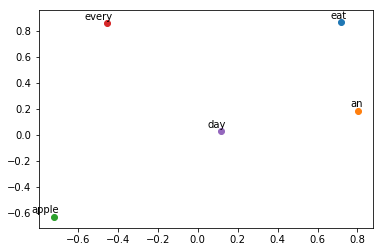

Weights (1) The first line doesn't change:
(5, 2)
[[-0.23159575  0.53407955]
 [ 0.39432549  0.53531396]
 [ 0.84516543  0.18148607]
 [-0.4420341   0.17308934]
 [ 0.36033678 -0.8736195 ]]


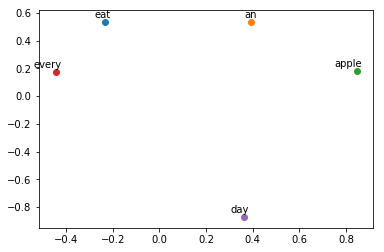

Loss value (1):
1.44171


In [85]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


input_voc = {0:"eat", 1:"an", 2:"apple", 3:"every", 4:"day"}
# eat an apple every day
# 0   1   2     3     4 
# batch contains - 2 training samples
# eat an  (0, 1)
# an apple (1, 2)
# negative samples for both cases - every, day (3, 4)

def plot_data(data):
    print(data)
    i = 0
    for (x, y) in data[:]:
        plt.annotate(input_voc[i], xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
        plt.scatter(x, y)
        i+=1
    plt.show()

vocab_size = 5
emb_dim = 2 
batch_size = 2
neg_samples = 2

examples = tf.placeholder(tf.int32, shape=[batch_size])
labels = tf.placeholder(tf.int32, shape=[batch_size])
sampled_ids = tf.placeholder(tf.int32, shape=[neg_samples])

emb = tf.Variable(tf.random_uniform([vocab_size, emb_dim], -1.0, 1.0), name="emb")
sm_w_t = tf.Variable(tf.random_uniform([vocab_size, emb_dim], -1.0, 1.0), name="sm_w_t")
sm_b = tf.Variable(tf.random_uniform([vocab_size], -1.0, 1.0), name="sm_b")

example_emb = tf.nn.embedding_lookup(emb, examples)
true_w = tf.nn.embedding_lookup(sm_w_t, labels)
true_b = tf.nn.embedding_lookup(sm_b, labels)
true_logits = tf.reduce_sum(tf.multiply(example_emb, true_w), 1) + true_b

true_xent = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(true_logits), logits=true_logits)

sampled_w = tf.nn.embedding_lookup(sm_w_t, sampled_ids)
sampled_b = tf.nn.embedding_lookup(sm_b, sampled_ids)
sampled_logits = tf.matmul(example_emb, sampled_w, transpose_b=True) + sampled_b

sampled_xent = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(sampled_logits), logits=sampled_logits)

# Loss function
nce_loss_tensor = (tf.reduce_sum(true_xent) + tf.reduce_sum(sampled_xent)) / batch_size

# ----------------------------------------------------------------------------------------------------------------

sess = tf.Session()
sess.run(tf.global_variables_initializer())

examples_b = [0, 1]
labels_b = [1, 2]
negative_samples_b = [3, 4]

e = sess.run(emb)
print("Embeddings:")
print(e.shape)
plot_data(e)

print("Weights:")
w = sess.run(sm_w_t)
print(w.shape)
plot_data(w)

print("Sampled Weights:")
print(sampled_w.shape)

input_dict = {examples:examples_b, labels:labels_b, sampled_ids:negative_samples_b}

for step in range(10):
    # Feed forward
    t = sess.run(nce_loss_tensor, feed_dict=input_dict);

    # Compute Gradients (Just for illustrative purposes, the gradients are computed in the Feed forward pass)
    #sess.run(tf.gradients(nce_loss_tensor, [emb, sm_w_t, sm_b]), feed_dict=input_dict)

    # Optimizer (just run 1 iteration and check updated weights)
    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(nce_loss_tensor)
    sess.run(train_step, feed_dict=input_dict)

print("Embeddings (1) Only the first two lines change!:")
e = sess.run(emb)
print(e.shape)
plot_data(e)

print("Weights (1) The first line doesn't change:")
w = sess.run(sm_w_t)
print(w.shape)
plot_data(w)

t = sess.run(nce_loss_tensor, feed_dict=input_dict);
print("Loss value (1):")
print(t)


In [42]:
# [v.name for v in tf.get_collection("variables")]
# Here we see that only 4 edges are computed (it knows that first row is not touched)
sess.run(tf.gradients(nce_loss_tensor, sm_w_t), feed_dict=input_dict)

[IndexedSlicesValue(values=array([[ 0.12727784,  0.0281038 ],
       [ 0.21380614,  0.02022013],
       [-0.11965735, -0.08621018],
       [-0.13348596,  0.03865439]], dtype=float32), indices=array([3, 4, 1, 2], dtype=int32), dense_shape=array([5, 2], dtype=int32))]

In [43]:
sess.run(tf.gradients(nce_loss_tensor, sm_b), feed_dict=input_dict)

[IndexedSlicesValue(values=array([-0.29215938, -0.24697435,  0.27352625,  0.44367576], dtype=float32), indices=array([1, 2, 3, 4], dtype=int32), dense_shape=array([5], dtype=int32))]

In [44]:
sess.run(tf.gradients(nce_loss_tensor, emb), feed_dict=input_dict)

[IndexedSlicesValue(values=array([[-0.02090145,  0.21195273],
       [ 0.03064499, -0.1736414 ]], dtype=float32), indices=array([0, 1], dtype=int32), dense_shape=array([5, 2], dtype=int32))]